In [1]:
# core
import simpy
import numpy as np
import matplotlib.pyplot as plt

# exercise 15-2
from scipy.optimize import minimize

#### *NOTE*

I've opted to use the standard `simpy` package for these exercises, as I'd like to better learn the more common syntax, rather than rely on the custom `modsim` functions. So, the syntax may vary slightly from that used in other exercises, but the results should be consistent.

For my two exercises, I chose Chapter 15 (which contains a two-part exercise) and Chapter 20.

# Chapter 15

### Exercise 1

Simulate the temperature of 50 mL of milk with a starting temperature of 5 °C, in a vessel with `r=0.1`, for 15 minutes, and plot the results. Use `make_system` to make a `System` object that represents the milk, and use `run_simulation` to simulate it.
By trial and error, find a value for `r` that makes the final temperature close to 20°C.

#### Response

First, I create a MilkSimulation class to model the cooling process of the milk. The cooling_process method updates the temperature of the milk over time according to Newton's Law of Cooling (as described in Chapter 15). The run_simulation function initializes the SimPy environment and runs the simulation for a given time. Then, we set up the given constants and loop through various values of `r` to see which gives us a final temperature close to 20°C.

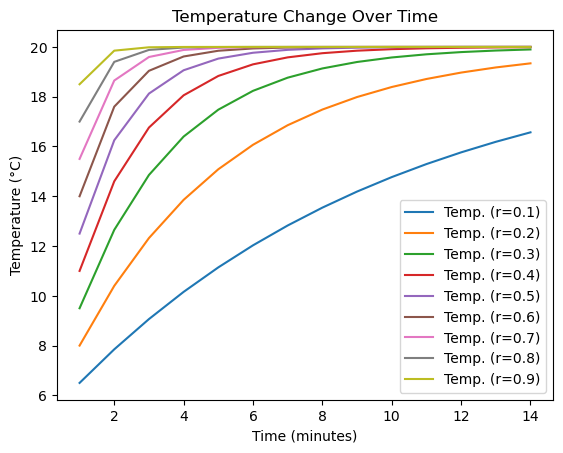

In [2]:
class MilkSimulation:
    def __init__(self, env, T_init, T_env, r):
        self.env = env
        self.T = T_init
        self.T_env = T_env
        self.r = r
        self.time = []
        self.temperature = []

    def cooling_process(self):
        while True:
            dTdt = -self.r * (self.T - self.T_env)
            yield self.env.timeout(1)  # Advance simulation by 1 minute
            self.T += dTdt
            self.time.append(self.env.now)
            self.temperature.append(self.T)

def run_simulation(T_init, T_env, r, sim_time=15):
    env = simpy.Environment()
    milk = MilkSimulation(env, T_init, T_env, r)
    env.process(milk.cooling_process())
    env.run(until=sim_time)
    return milk.time, milk.temperature

# Initial conditions and parameters
T_init = 5
T_env = 20
r = 0.1
sim_time = 15

# Run the simulation for different values of r
for r in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    time, temperature = run_simulation(T_init, T_env, r, sim_time)
    plt.plot(time, temperature, label=f'Temp. (r={r})')

# Plot results
plt.xlabel('Time (minutes)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Change Over Time')
plt.legend()
plt.show()

It seems that, as `r` approaches 1, the final temperature converges to 20°C

### Exercise 2

Write an error function that simulates the temperature of the milk and returns the difference between the final temperature and 20 °C.  Use it to estimate the value of `r` for the milk.

#### Response

We can use a similar approach as shown above, but we'll explicitly define the difference between the final temperature and our goal temperature. We also use the `scipy` function `minimize` to find the optimal values that minimizes the difference over the course of the simulation.

Optimal r value: 1.1100000000000003


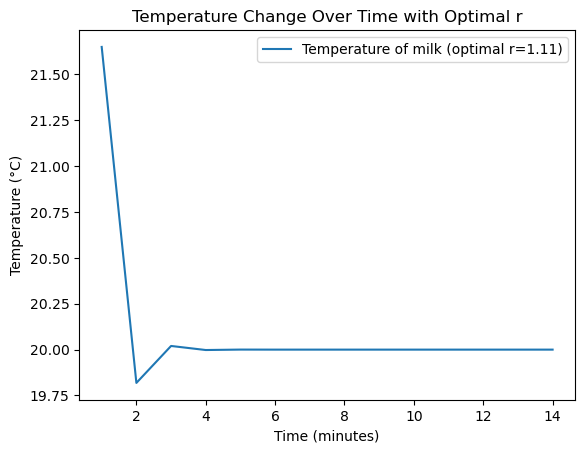

In [3]:
# Define the error function
def error_function(r_value):
    r = r_value[0]
    time, temperature = run_simulation(T_init, T_env, r, sim_time)
    final_temperature = temperature[-1]
    return abs(final_temperature - 20)

# Optimize the value of r
result = minimize(error_function, x0=[0.1])
optimal_r = result.x[0]
print(f'Optimal r value: {optimal_r}')

# Run simulation with the optimal r value
time_optimal, temperature_optimal = run_simulation(T_init, T_env, optimal_r, sim_time)

# Plot results
plt.plot(time_optimal, temperature_optimal, label=f'Temperature of milk (optimal r={optimal_r:.2f})')
plt.xlabel('Time (minutes)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Change Over Time with Optimal r')
plt.legend()
plt.show()

Here, we find that the optimal `r` is actually above 1. With this value, the temperature quickly drops, then settles right around 20°C.

# Chapter 18

### Exercise 1

Our solution to the differential equations is only approximate because we used a finite step size, `dt=2` minutes. If we make the step size smaller, we expect the solution to be more accurate.  Run the simulation with `dt=1` and compare the results.  What is the largest relative error between the two solutions?

#### Response

We'll use a similar set as dictated with the `run_simulation` example in Chapter 20. We must first define some key parameters, including two rate constants for glucose metabolism, initial concentrations of glucose and insulin, and the time steps to be used in each simulation (as dicatted by the exercise). We then define a function to simualte glucose-insulin dynamics, again pulling from Chapter 18. Finally, we run each simulation with the varied values for `dt`, keeping all else consistent. I wanted to try using an `Environment` object, which overall seems quite similar to the `State` object, but has some different functionality (as I've read from others, anyway!). Last, we then measure the relative errors and plot them. Because the second simulation has half as many observations (because it uses a larger step size), we interpolate the values in between each step.

Largest relative error for Glucose: 0.7973070315330307
Largest relative error for Insulin: 0.7711149430691878


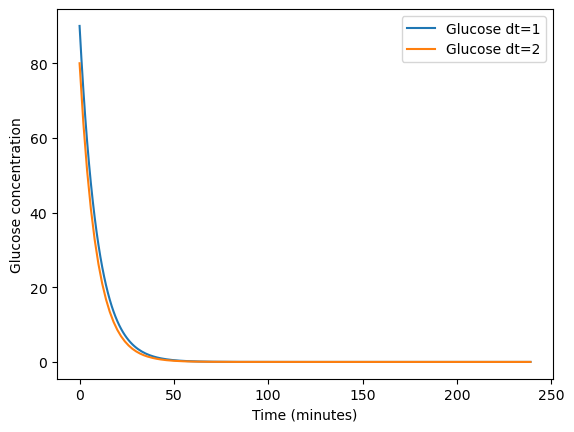

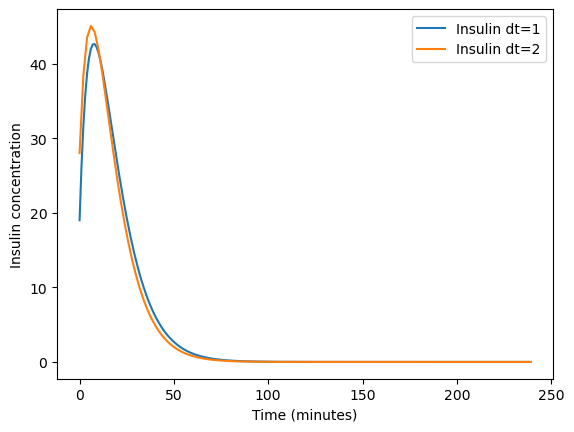

In [7]:
# Define the parameters
k1 = 0.1 # rate constant 1
k2 = 0.1 # rate constant 2
G0 = 100  # Initial glucose concentration
X0 = 10   # Initial insulin concentration
dt1 = 1   # Time step for first simulation
dt2 = 2   # Time step for second simulation
T = 240   # Total time for simulation

# Helper function to simulate glucose-insulin dynamics
def glucose_insulin(env, G, X, k1, k2, dt, times, G_values, X_values):
    while env.now < T:
        dG = -k1 * G * dt
        dX = k2 * (G - X) * dt
        G += dG
        X += dX
        
        times.append(env.now)
        G_values.append(G)
        X_values.append(X)
        
        yield env.timeout(dt)

# Run first simulation with dt1
env1 = simpy.Environment()
times1, G_values1, X_values1 = [], [], []
env1.process(glucose_insulin(env1, G0, X0, k1, k2, dt1, times1, G_values1, X_values1))
env1.run(until=T)

# Run second simulation with dt2
env2 = simpy.Environment()
times2, G_values2, X_values2 = [], [], []
env2.process(glucose_insulin(env2, G0, X0, k1, k2, dt2, times2, G_values2, X_values2))
env2.run(until=T)

# Interpolating results for comparison
G_values2_interp = np.interp(times1, times2, G_values2)
X_values2_interp = np.interp(times1, times2, X_values2)

# Calculate relative errors
G_relative_error = np.abs((np.array(G_values1) - np.array(G_values2_interp)) / np.array(G_values1))
X_relative_error = np.abs((np.array(X_values1) - np.array(X_values2_interp)) / np.array(X_values1))

# Find the largest relative error
max_G_error = np.max(G_relative_error)
max_X_error = np.max(X_relative_error)

print(f"Largest relative error for Glucose: {max_G_error}")
print(f"Largest relative error for Insulin: {max_X_error}")

# Plot results
plt.plot(times1, G_values1, label='Glucose dt=1')
plt.plot(times1, G_values2_interp, label='Glucose dt=2')
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose concentration')
plt.legend()
plt.show()

plt.plot(times1, X_values1, label='Insulin dt=1')
plt.plot(times1, X_values2_interp, label='Insulin dt=2')
plt.xlabel('Time (minutes)')
plt.ylabel('Insulin concentration')
plt.legend()
plt.show()

It seems that, over time, the two simulations converge to zero, as expected. The two simulations appear to track quite closely, however, the greatest differences emerge at the beginning of the series.